In [1]:
import os
import json
import time
import copy
from copy import deepcopy
from collections import defaultdict

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models

from skimage import io

import matplotlib.pyplot as plt
from matplotlib import patches, patheffects

import imgaug as ia
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [2]:
# from torchsummary import summary

In [3]:
# PATH_ANNO = r'../input/pascal_voc/PASCAL_VOC/pascal_train2007.json'
# PATH_IMG = r'../input/voctrainval_06-nov-2007/VOCdevkit/VOC2007/JPEGImages'
PATH_ANNO = r'/home/spacor/fastai/courses/dl2/data/PASCAL_VOC/pascal_train2007.json'
PATH_IMG = r'/home/spacor/fastai/courses/dl2/data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages'

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 16
VAL_SIZE =0.33
# DEVICE = torch.device("cpu")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def get_img_annotations(path_annotations):
    """
    load raw img annotations
    bbox format is x-min, y-min, w, h
    """
    anno_raw=json.load(open(path_annotations))
    imgId_anno_map = defaultdict(list)
    for i in anno_raw['annotations']:
        imgId_anno_map[i['image_id']].append(i)
    img_anno = []
    for i in anno_raw['images']:
        tmp_anno = imgId_anno_map[i['id']]
        tmp_rcd = i
        tmp_rcd['annotation'] = tmp_anno
        img_anno.append(tmp_rcd)
    return img_anno

def transform_anno(raw_annotations):
    """
    transform raw img annotation into transformed annotation
    transform bbox format from x-min, y-min, w, h to
    y-min, x-min, y-max, x-max
    """
    transformed_annotations = []
    for raw_annotation in raw_annotations:
        tfm_bbox = lambda raw_bbox: (raw_bbox[1], raw_bbox[0], raw_bbox[3]+raw_bbox[1]-1, raw_bbox[2]+raw_bbox[0]-1)
        tmp_anno = {'filename': raw_annotation['file_name'],
                   'bboxes': [{'bbox': tfm_bbox(i['bbox']), 'category_id': i['category_id']} for i in raw_annotation['annotation']]
                   }
        transformed_annotations.append(tmp_anno)
    return transformed_annotations

def get_obj_category_mappings(path_annotations):
    anno_raw=json.load(open(path_annotations))
    catId_name_map = dict()
    for i in anno_raw['categories']:
        catId_name_map[i['id']] = i['name']
    return catId_name_map

In [6]:
#transform bbox convention functions

def bbtfm_bb2wh(bbox):
    """
    transform bbox from
    y-min, x-min, y-max, x-max
    to
    x-min, y-min, w, h
    """
    alt_bb_fmt = bbox[1], bbox[0], bbox[3] - bbox[1] - 1, bbox[2] - bbox[0] - 1
    return alt_bb_fmt

def bbtfm_bb2xy(bbox):
    """
    transform bbox from
    y-min, x-min, y-max, x-max
    to
    x-min, y-min, x-max, y-max
    """
    alt_bb_fmt = bbox[1], bbox[0], bbox[3], bbox[2]
    return alt_bb_fmt

def bbtfm_xy2bb(bbox):
    """
    transform bbox from
    x-min, y-min, x-max, y-max
    to
    y-min, x-min, y-max, x-max
    """
    alt_bb_fmt = bbox[1], bbox[0], bbox[3], bbox[2]
    return alt_bb_fmt

In [7]:
img_anno = transform_anno(get_img_annotations(PATH_ANNO)) #img annotation
img_cate_map = get_obj_category_mappings(PATH_ANNO) #cat ID to cat des
img_cate_map[0] = 'BG'

MAX_BBOX = int(np.array([len(i['bboxes']) for i in img_anno]).max()) #max num of bbox #max number of bounding box in sample
NUM_CLASS = len(img_cate_map) #num class, reserve 0 for background
NUM_CLASS_wo_BG = NUM_CLASS - 1
img_anno[1]

{'filename': '000017.jpg',
 'bboxes': [{'bbox': (61, 184, 198, 278), 'category_id': 15},
  {'bbox': (77, 89, 335, 402), 'category_id': 13}]}

In [8]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_rect(ax, b):
    """
    b: bounding box (list) top left point coordinate, width, height (x, y, w, h)
    """
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

def show_img_bbs(img, bboxes, texts):
    """
    Show img alongside with all bboxes
    img: np array of image
    bboxes: list of bbox in y-min, x-min, y-max, x-max
    texts: list of annotation (categories) of bbox
    """
    ax = show_img(img)
    for tmp_bbox, tmp_text in zip(bboxes, texts):
        bb = bbtfm_bb2wh(tmp_bbox)
        draw_rect(ax, bb)
        draw_text(ax, bb[:2], tmp_text)

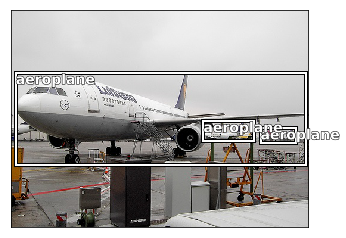

In [9]:
#test show image and bounding box
idx = 5
tmp = img_anno[idx]
tmp_img = io.imread(os.path.join(PATH_IMG, tmp['filename']))
tmp_bb = [i['bbox'] for i in tmp['bboxes']]
tmp_cat = [img_cate_map[i['category_id']] for i in tmp['bboxes']]

show_img_bbs(tmp_img, tmp_bb, tmp_cat)

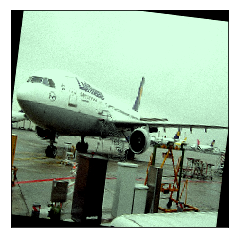

In [10]:
#Test augmentation - img only
seq = iaa.Sequential([
    iaa.Scale({"height": IMG_SIZE, "width": IMG_SIZE}),
    iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Sometimes(0.5,
            iaa.GaussianBlur(sigma=(0, 0.5))
        ),
        iaa.ContrastNormalization((0.75, 1.5)),
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        iaa.Multiply((0.8, 1.2), per_channel=0.2),
        iaa.Affine(
            rotate=(-10, 10),
        )
    ], random_order=True) # apply augmenters in random order
], random_order=False)

tmp_tfm_img = seq.augment_images([tmp_img.copy(),tmp_img.copy()])
show_img_bbs(tmp_tfm_img[0], [], [])

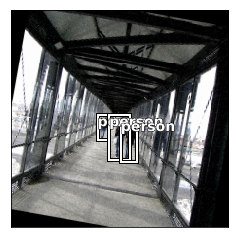

In [11]:
#Test augmentation - img + bbox
seq = iaa.Sequential([
    iaa.Scale({"height": IMG_SIZE, "width": IMG_SIZE}),
    iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Sometimes(0.5,
            iaa.GaussianBlur(sigma=(0, 0.5))
        ),
        iaa.ContrastNormalization((0.75, 1.5)),
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        iaa.Multiply((0.8, 1.2), per_channel=0.2),
        iaa.Affine(
            rotate=(-10, 10),
        )
    ], random_order=True) # apply augmenters in random order
], random_order=False)
# convert_bb_fmt = lambda bb: [bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]] #convert topleft xy, wh to min x, min y, max x,  max y

#read raw data
idx = 15
tmp = img_anno[idx]
tmp_img = io.imread(os.path.join(PATH_IMG, tmp['filename']))
tmp_bb = [i['bbox'] for i in tmp['bboxes']]
tmp_bb_obj = ia.BoundingBoxesOnImage([ia.BoundingBox(*bbtfm_bb2xy(i)) for i in tmp_bb], shape=tmp_img.shape) #convert to Boundingboxes object
tmp_cat = [img_cate_map[i['category_id']] for i in tmp['bboxes']]

#augmentation
extract_bb = lambda bb_obj: [bb_obj.y1_int, bb_obj.x1_int, bb_obj.y2_int, bb_obj.x2_int]

seq_det = seq.to_deterministic()

tmp_aug_img = seq_det.augment_images([tmp_img.copy()])[0]
tmp_aug_bbs_raw = seq_det.augment_bounding_boxes([tmp_bb_obj])[0]
tmp_aug_bbs=[]
for b in tmp_aug_bbs_raw.bounding_boxes:
    if b.is_out_of_image(tmp_aug_img):
        bb = [0.0,0.0,0.0,0.0] #dummy for out of image bb
        print('bb out of bound')
    else:
        bb = extract_bb(b.cut_out_of_image(tmp_aug_img))
    tmp_aug_bbs.append(bb)

# #display
show_img_bbs(tmp_aug_img, tmp_aug_bbs, tmp_cat)

In [12]:
class PascalDataset(Dataset):
    def __init__(self, img_meta, transform = None):
        self.img_meta = img_meta
        self.transform = transform
        self.num_bboxes = 5
#         self.num_bboxes = MAX_BBOX
        self.bbox_co_len = 4 #number of parameter defines a bbox

        
    def __len__(self):
        return len(self.img_meta)
    
#     def _pad(self, original_seq, size, padding):
#         seq = (original_seq + [padding] * abs((len(original_seq)-size)))[:size]
#         return seq
    
    def __getitem__(self, idx):
        
        img = io.imread(os.path.join(PATH_IMG, self.img_meta[idx]['filename']))
        
#         bboxes = [i['bbox'] for i in self.img_meta[idx]['bboxes']]
#         bboxes = self._pad(bboxes, self.num_bboxes, [0,0,1,1]) #padding; dummy for pad
#         categories = [i['category_id'] for i in self.img_meta[idx]['bboxes']]
#         categories = self._pad(categories, self.num_bboxes, 0) #padding; dummy for pad
        
#         if bool(self.transform) is True:
#             img_boxes = (img, bboxes)
#             img, bboxes = self.transform(img_boxes)
        
#         categories = torch.tensor(categories)
    
        #read bboxes
        bboxes = [i['bbox'] for i in self.img_meta[idx]['bboxes']]
        
        #read cate
        categories = [i['category_id'] for i in self.img_meta[idx]['bboxes']]
        
        #augmentation
        if bool(self.transform) is True:
            img_bb_cat = (img, bboxes, categories)
            img, bboxes, categories = self.transform(img_bb_cat)
            
        #pad
        bboxes = np.pad(np.array(bboxes).flatten(), pad_width = (0, self.num_bboxes * self.bbox_co_len), mode = 'constant', constant_values=(0,0))[:self.num_bboxes * self.bbox_co_len]
        categories = np.pad(np.array(categories), pad_width = (0, self.num_bboxes), mode = 'constant', constant_values=(0,0))[:self.num_bboxes]
        
        #transform to tensor
        img = img #already transformed to torch tensor in transformation
        bboxes = torch.from_numpy(bboxes).float()
        categories = torch.from_numpy(categories)
        
        output = (img, (bboxes, categories))
        return output

class NormalizeImg:
    def __init__(self):
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
        
    def __call__(self, img_bb_cat):
        img, bboxes, categories = img_bb_cat
        
        
        #transform img to tensor
        img = np.clip(img, a_min=0, a_max=None)
        img = img.transpose((2, 0, 1))
        img = torch.from_numpy(img).float().div(255)
        #normalize
        img = self.normalize(img)

        img_bb_cat = (img, bboxes, categories)
        return img_bb_cat

class ImgBBoxTfm:
    def __init__(self, output_size = 224, aug_pipline = None):
        self.output_size = output_size
        self.seq = aug_pipline
    
    def __call__(self, img_bb_cat):
        """
        img_boxes: tuple of image, bboxes. bboxes are array of bbox
        """
        img, bboxes, categories = img_bb_cat
#         convert_bb_fmt = lambda bb: [bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]] #convert topleft xy, wh to min x, min y, max x,  max y
#         reverse_bb_fmt = lambda bb_obj: [bb_obj.x1_int, bb_obj.y1_int, int(bb_obj.width), int(bb_obj.height)]
        extract_bb = lambda bb_obj: [bb_obj.y1_int, bb_obj.x1_int, bb_obj.y2_int, bb_obj.x2_int]
        raw_image = img
        raw_bbs = ia.BoundingBoxesOnImage([
            ia.BoundingBox(*bbtfm_bb2xy(bb)) for bb in bboxes
        ], shape=raw_image.shape)
        
        seq_det = self.seq.to_deterministic()
        image_aug = seq_det.augment_images([raw_image])[0]
        
        bbs_aug_raw = seq_det.augment_bounding_boxes([raw_bbs])[0]
        bbs_aug=[]
        cate_filtered = []
        for ix, b in enumerate(bbs_aug_raw.bounding_boxes):
            if b.is_out_of_image(image_aug):
                bb = [0,0,0,0] #dummy for out of image bb
                c = 0 #assign category of out of image to BG
            else:
                bb = extract_bb(b.cut_out_of_image(image_aug))
                c = categories[ix]
            bbs_aug.append(bb)
            cate_filtered.append(c)
        img_bb_cat = (image_aug, bbs_aug, cate_filtered)
        return img_bb_cat

In [13]:
def get_aug_pipline(img_size, mode = 'train'):
    if mode == 'train':
        seq = iaa.Sequential([
            iaa.Scale({"height": img_size, "width": img_size}),
            iaa.Sequential([
                iaa.Fliplr(0.5),
                iaa.Sometimes(0.5,
                    iaa.GaussianBlur(sigma=(0, 0.5))
                ),
                iaa.ContrastNormalization((0.75, 1.5)),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                iaa.Multiply((0.8, 1.2), per_channel=0.2),
                iaa.Affine(
                    rotate=(-10, 10),
                )
            ], random_order=True) # apply augmenters in random order
        ], random_order=False)
    else: #ie.val
        seq = iaa.Sequential([
            iaa.Scale({"height": img_size, "width": img_size}),
        ], random_order=False)
    return seq

In [14]:
def inverse_transform(img_torch):
    """denormalize and inverse transform img"""
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
        std=[1/0.229, 1/0.224, 1/0.255]
    )
    tmp = deepcopy(img_torch)
    inv_normalize(tmp)
    tmp = np.clip((tmp.numpy().transpose((1,2,0)) * 255), a_min=0, a_max=255).astype(np.int)
    return tmp

In [15]:
train_set, val_set = train_test_split(img_anno, test_size=VAL_SIZE, random_state=42)

composed = {}
composed['train'] = transforms.Compose([ImgBBoxTfm(output_size=IMG_SIZE, aug_pipline=get_aug_pipline(img_size=IMG_SIZE, mode = 'train')), 
                                     NormalizeImg()])
composed['val'] = transforms.Compose([ImgBBoxTfm(output_size=IMG_SIZE, aug_pipline=get_aug_pipline(img_size=IMG_SIZE, mode = 'val')), 
                                     NormalizeImg()])

image_datasets = {'train': PascalDataset(train_set, transform=composed['train']),
                 'val': PascalDataset(val_set, transform=composed['val'])}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=1, drop_last=True)
              for x in ['train', 'val']}

In [16]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

{'train': 1675, 'val': 826}


In [17]:
#test dataset and transformation pipline

ix = 11
tmp = image_datasets['train'][ix]
tmp_img = tmp[0]
tmp_bb_mask = tmp[1][1].numpy() > 0
tmp_bboxes = tmp[1][0].numpy().reshape((-1,4))[tmp_bb_mask]
tmp_cat = ['{}: {}'.format(int(i), img_cate_map[i]) for i in list(tmp[1][1].numpy()[tmp_bb_mask])]

# show_img_bbs(inverse_transform(tmp_img), tmp_bboxes, tmp_cat) 

In [18]:
def show_batch_img_bbs(imgs, bboxes, catagories):
    thusholds = 0.4
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for ix,ax in enumerate(axes.flat):
        tmp_img = inverse_transform(imgs[ix])
        tmp_bb_mask = catagories[ix].numpy() > 0
        tmp_cate = [i for i in list(catagories[ix].numpy()[tmp_bb_mask])]
        tmp_bboxes = bboxes[ix].numpy().reshape((-1,4))[tmp_bb_mask]
        bb_des = ['{}: {}'.format(i, img_cate_map[i]) for i in tmp_cate]
#         bb_tfm = [BboxCenterTfmReverse(i) for i in reverse_bb(tmp_bboxes[non_bg])]
        ax = show_img(tmp_img, ax=ax)
        for bb, t in zip(tmp_bboxes, bb_des):
            draw_rect(ax, bbtfm_bb2wh(bb))
            draw_text(ax, bb[:2], t)

In [19]:
#test dataloader
inputs, (bbox, cate) = next(iter(dataloaders['train']))
# show_batch_img_bbs(inputs, bbox, cate)

In [20]:
class Flatten(nn.Module):
    def __init__(self): 
        super().__init__()
    def forward(self, x): 
        return x.view(x.size(0), -1)

class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, NUM_CLASS*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [
            flatten_conv(self.oconv2(x), self.k), 
            flatten_conv(self.oconv1(x), self.k)
                ]

class RnetBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = self._prep_backbone()
        
    def _prep_backbone(self):     
        base_model = models.resnet34(pretrained=True)
        removed = list(base_model.children())[:-2]
        backbone = nn.Sequential(*removed)
        for param in backbone.parameters():
            param.require_grad = False
        return backbone
    
    def forward(self, x):
        x = self.backbone(x)
        return x
    
class RNetCustom(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.backbone = RnetBackbone()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv2(x)
        x = self.out(x)

        return x

In [21]:
# summary(model_ft, (3, IMG_SIZE, IMG_SIZE), device = 'cpu')

In [22]:
#prep anchor
k = 1
anc_grid = 4

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])

anchors = torch.tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

In [23]:
grid_sizes = torch.tensor(np.array([1/anc_grid]), requires_grad=False).float().unsqueeze(1)
grid_sizes

tensor([[0.2500]])

In [24]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1) #convert center y,x, h, w to top-left y,x bottom right y,x

In [25]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

tensor([[0.0000, 0.0000, 0.2500, 0.2500],
        [0.0000, 0.2500, 0.2500, 0.5000],
        [0.0000, 0.5000, 0.2500, 0.7500],
        [0.0000, 0.7500, 0.2500, 1.0000],
        [0.2500, 0.0000, 0.5000, 0.2500],
        [0.2500, 0.2500, 0.5000, 0.5000],
        [0.2500, 0.5000, 0.5000, 0.7500],
        [0.2500, 0.7500, 0.5000, 1.0000],
        [0.5000, 0.0000, 0.7500, 0.2500],
        [0.5000, 0.2500, 0.7500, 0.5000],
        [0.5000, 0.5000, 0.7500, 0.7500],
        [0.5000, 0.7500, 0.7500, 1.0000],
        [0.7500, 0.0000, 1.0000, 0.2500],
        [0.7500, 0.2500, 1.0000, 0.5000],
        [0.7500, 0.5000, 1.0000, 0.7500],
        [0.7500, 0.7500, 1.0000, 1.0000]])

In [26]:
n_clas = NUM_CLASS
n_act = k*(4+n_clas)
n_act

25

In [27]:
# prep loss
def prep_y_true(y_true_bb, y_true_cat):
    """
    prep y_true for loss calc
    y_true_bb: shape (num bb * 4)
    y_true_cat: shape (num bb)
    return
    y_true_bb: (num of bb to keep, 4)
    y_true_cat: (num of bb to keep)
    """
    bb = y_true_bb.reshape(-1, 4) #reshape to -1, 4
    bb = bb.div(IMG_SIZE) #rescale bb dim relative to img size
    bb_keep_mask = y_true_cat > 0 #remove bb with cat of 0
    return bb[bb_keep_mask], y_true_cat[bb_keep_mask]

def prep_y_pred_bb(y_pred_bb, anchors):
#     print('y_pred_bb {}'.format(y_pred_bb.shape))
    y_pred_bb = F.tanh(y_pred_bb) #squish between -1 to +1
    y_pred_bb_tfm_center = (y_pred_bb[:, :2] / 2 * grid_sizes) + anchors[:, :2] #adj anchor center with pred
    y_pred_bb_tfm_hw = (y_pred_bb[:, 2:] / 2 + 1) * anchors[:, 2:] #adj anchor hw with pred
    y_pred_bb_tfm = hw2corners(y_pred_bb_tfm_center, y_pred_bb_tfm_hw) 
    return y_pred_bb_tfm

In [28]:
def intersect(box_a, box_b):
    """
    box_a & box_b: min-y, min-x, max-y, max-x
    """
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]


def box_sz(b): return ((b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1]))


def jaccard(box_a, box_b):
    """
    :param box_a: y_true_bbox x (min-y, min-x, max-y, max-x)
    :param box_b: anchors x (min-y, min-x, max-y, max-x)
    :return: iou
    """
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [29]:
def map_to_ground_truth(overlaps):
    """
    for each piror-box/predictions assign ground true with highest iou
    then for each ground true assign its highest iou to piror-box;
    
    another way saying is
    
    for each ground true, assign to highest iou piror box
    then for the rest unassigned piror box, assign ground true base highest iou
    """
    prior_overlap, prior_idx = overlaps.max(1)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i, o in enumerate(prior_idx): 
        gt_idx[o] = i
    return gt_overlap, gt_idx

In [30]:
def one_hot_embedding(labels, num_classes):
    onehot = torch.eye(num_classes)[labels.data.cpu()]
    onehot = onehot.to(DEVICE)
    return onehot

class BCE_Loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred_cat, y_true_cat):
        t = one_hot_embedding(y_true_cat, NUM_CLASS)
        t = t[:, 1:] #remove background from ground true as it doesnt count in error
        x = y_pred_cat[:, 1:] #remove background from prediction as it doesnt count in error
        w = self.get_weight(x,t)
#         print('x {}, t {}'.format(x.type(), t.type()))
        loss_cate = F.binary_cross_entropy_with_logits(x, t, w, reduction='sum') / NUM_CLASS_wo_BG
        return loss_cate
    
    def get_weight(self,x,t): 
        return None

loss_f = BCE_Loss()

In [31]:
#calc location loss
def calc_ssd_loss_single(y_pred_bb, y_pred_cat, y_true_bb, y_true_cat):
#     print('y_true_bb {}, y_pred_bb {}, y_true_cat {}, y_pred_cat {}'.format(y_true_bb.shape, y_pred_bb.shape, y_true_cat.shape, y_pred_cat.shape))
    y_true_tfm_bb, y_true_tfm_cat = prep_y_true(y_true_bb, y_true_cat)
    overlaps = jaccard(y_true_tfm_bb.data, anchor_cnr.data)
    y_true_overlap, y_true_overlap_idx = map_to_ground_truth(overlaps)
    pos = y_true_overlap > 0.4 #only count those piror-box : ground-true mapping with greater than 0.4; pos acts as a mask
    pos_idx = torch.nonzero(pos)[:, 0] #index of pos
    y_pred_tfm_bb = prep_y_pred_bb(y_pred_bb, anchors)
    gt_bbox = y_pred_tfm_bb[y_true_overlap_idx]
    bb_loss = ((y_pred_tfm_bb[pos_idx] - gt_bbox[pos_idx]).abs()).mean()

    #calc classification loss
    gt_clas = y_true_cat[y_true_overlap_idx]
    gt_clas[1 - pos] = 0 #assign masked piror box to BG
    cat_loss = loss_f(y_pred_cat, gt_clas)

    return bb_loss, cat_loss

def calc_ssd_loss_batch(y_pred, y_true):
    cum_bb_loss, cum_cat_loss = 0., 0.
    for y_pred_bb, y_pred_cat, y_true_bb, y_true_cat in zip(*y_pred, *y_true):
        bb_loss, cat_loss = calc_ssd_loss_single(y_pred_bb, y_pred_cat, y_true_bb, y_true_cat)
        cum_bb_loss += bb_loss
        cum_cat_loss+= cat_loss
    cum_loss = cum_bb_loss + cum_cat_loss
    return cum_loss

In [32]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, targets in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                
                y_true_bb, y_true_cat = targets
                y_true_bb = y_true_bb.to(DEVICE)
                y_true_cat = y_true_cat.to(DEVICE)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, [y_true_bb, y_true_cat])

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == categories.data)

            epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_acc = 0 #for bbox only training
    
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
#     model.load_state_dict(best_model_wts)
    return model

In [33]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = RNetCustom(k, -3.)
model_ft = model_ft.to(DEVICE)
anchor_cnr = anchor_cnr.to(DEVICE)
anchors = anchors.to(DEVICE)
grid_sizes=grid_sizes.to(DEVICE)
criterion = calc_ssd_loss_batch

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [34]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------


/home/spacor/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


train Loss: 13.6038 Acc: 0.0000
val Loss: 9.9186 Acc: 0.0000
Epoch 1/4
----------
train Loss: 9.4951 Acc: 0.0000
val Loss: 9.0264 Acc: 0.0000
Epoch 2/4
----------
train Loss: 8.6081 Acc: 0.0000
val Loss: 8.6430 Acc: 0.0000
Epoch 3/4
----------
train Loss: 8.0413 Acc: 0.0000
val Loss: 8.5977 Acc: 0.0000
Epoch 4/4
----------
train Loss: 7.5652 Acc: 0.0000
val Loss: 8.6466 Acc: 0.0000
Training complete in 2m 50s


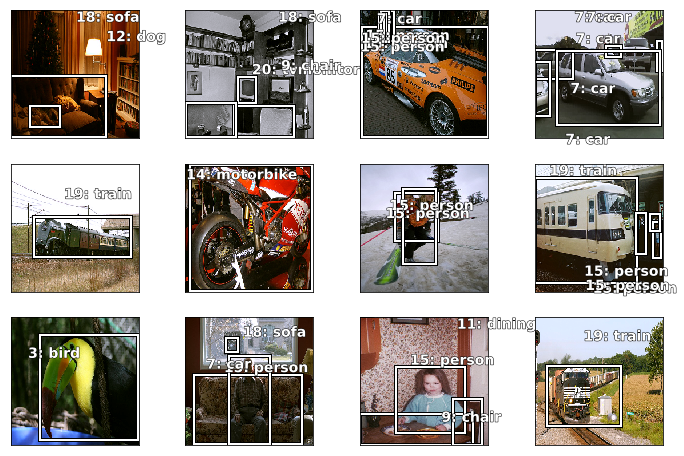

In [35]:
#look at some example
inputs, (y_true_bb, y_true_cat) = next(iter(dataloaders['val']))
show_batch_img_bbs(inputs, y_true_bb, y_true_cat)

In [36]:
with torch.no_grad():
    inputs = inputs.to(DEVICE)
    y_pred = model_ft(inputs)

In [37]:
y_pred_bb, y_pred_cat = y_pred
y_pred_bb = y_pred_bb.cpu()
y_pred_cat = y_pred_cat.cpu()

In [56]:
idx = 8
tmp_img = inverse_transform(inputs[idx].cpu())
tmp_pred_bb = y_pred_bb[idx]
tmp_pred_cat = y_pred_cat[idx]

cat_p, cat_idx = F.sigmoid(tmp_pred_cat).max(1)

/home/spacor/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


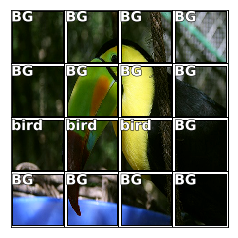

In [57]:
show_img_bbs(tmp_img, anchor_cnr.cpu().numpy() * IMG_SIZE, [img_cate_map[i] for i in cat_idx.numpy()])

In [58]:
y_pred_tfm_bb = prep_y_pred_bb(y_pred[0][idx], anchors).cpu()

/home/spacor/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [59]:
tmp_tfm_bb = y_pred_tfm_bb.cpu().numpy() * IMG_SIZE

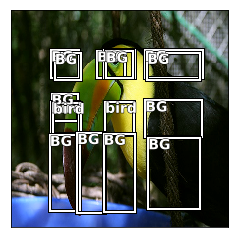

In [60]:
show_img_bbs(tmp_img, tmp_tfm_bb, [img_cate_map[i] for i in cat_idx.numpy()])